In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import os
from io import open
import glob
import string
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

import spacy.cli
import en_core_web_sm

from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#Load and prepare data from Rick and Morty

In [0]:
path = os.getcwd()
file_path = os.path.join(path, 'gdrive/My Drive/Colab Notebooks/Project DL/awd_lstm_lm_master/data/penn/RICK_AND_MORTY_ALL_EPISODES.txt')

In [0]:
# Run this once and then "Restart Runtime...""
#!python -m spacy download en_core_web_sm

### Tokenizing
Modify the below section if you are running PTB, i.e. if you set the path to PTB training set.

In [0]:
nlp = en_core_web_sm.load()
text_file = open(file_path).read()
token_file = nlp(text_file)
corpus = [token.text for token in token_file if not token.is_stop and not token.is_punct]

In [160]:
print(len(corpus))

61841


In [0]:
# Splitting the dataset in two
split = int(len(corpus)*0.8)
train_set = corpus[:split]
val_set = corpus[split:]

In [0]:
corpus_count = Counter(train_set) # Number of instances for each "word" in the training_set
train_set_unkd = ["unk" if corpus_count[word] <= 1 else word for word in train_set]
val_set_unkd = ["unk" if word not in train_set_unkd else word for word in val_set]
train_set = train_set_unkd
val_set = val_set_unkd

In [163]:
print(train_set)
print(val_set)
print(len(val_set))

['Open', 'Ext', 'Smith', 'residence', '\n ', 'Outside', 'unk', 'ground', 'Smith', 'house', '\n', 'unk', 'Christmas', 'Jerry', 'heard', 'singing', 'King', 'Christmas', '\n ', 'Jerry', '\n', 'singing', 'King', 'Christmas', 'arrived', '\n ', 'Trans', 'Int', 'unk', '\n ', 'kitchen', 'mess', 'food', 'stages', '\n', 'unk', 'Jerry', 'pulls', 'ham', 'unk', 'sings', '\n ', 'Jerry', 'singing', '\n', 'Christmas', 'Christmas', 'stops', 'singing', 'unk', 'ham', 'Mmm', 'Jerry', '\n', 'giving', 'ham', '\n ', 'Jerry', 'enters', 'living', 'room', 'tree', 'stands', '\n', 'unk', 'underneath', 'Beth', 'Morty', 'unk', 'unk', 'Summer', '\n', 'uses', 'unk', '\n ', 'Jerry', 'Um', '\n', 'Merry', 'Christmas', 'puts', 'hands', 'unk', 'unk', 'parents', 'coming', '\n', 'time', 'years', 'unk', 'gadgets', 'look', 'alive', '\n ', 'Beth', 'Alive', '\n', 'parents', '\n ', 'Jerry', 'unk', 'tablet', 'away', 'unk', 'stocking', '\n ', 'Jerry', 'Good', '\n', '\n ', 'Beth', 'Hey', 'man', '\n ', 'Jerry', 'hey', '\n', 'man', '

In [0]:
word_count = Counter(train_set) # Number of instances of each "word" in the trainingset
sorted_vocab = sorted(word_count, key=word_count.get, reverse=True)
idx_to_word ={idx: word for idx, word in enumerate(sorted_vocab)}
word_to_idx = {word: idx for idx, word in idx_to_word.items()}
vocab = len(idx_to_word) # Number of unique words

In [181]:
# Checking frquency of words
print(sorted_vocab)
print(word_count['Rick'])
print(word_count['Morty'])

['unk', '\n ', '\n', 'Rick', 'Morty', 'Jerry', '’s', 'Summer', 'Beth', 'know', 'Oh', 'like', 'n’t', 'Trans', 'got', 'gon', 'na', '’m', 'right', 'time', '’re', 'man', 'Mr.', 'Hey', '\xa0', 'think', 'Yeah', 'TV', 'Ricks', 'Pickle', '1', 'room', 'want', ' ', 'mean', 'Unity', 'going', 'Dr.', 'away', '2', 'Uh', 'people', 'thing', 'Mortys', 'portal', 'Smith', 'Okay', 'little', 'love', 'look', 'head', 'let', 'come', 'Meeseeks', 'guys', 'family', 'starts', 'Goldenfold', 'God', 'way', 'good', 'looks', 'need', 'car', 'walks', 'Look', 'gun', 'planet', 'Come', 'Jessica', 'door', 'life', 'C-137', 'garage', 'home', 'yeah', 'house', 'Vagina', 'okay', 'Yes', 'help', 'Earth', '♪', 'world', 'Whoa', 'Snuffles', '’ll', 'inside', 'Annie', 'puts', 'Dad', 'hell', 'Hemorrhage', 'Bloom', 'run', 'place', 'tell', 'President', 'Terry', 'pulls', 'guy', 'takes', 'work', '’ve', 'Principal', 'Transition', 'kind', 'Needful', 'Int', 'hand', 'T', 'stuff', 'stop', 'Ruben', 'grabs', 'face', 'Fart', 'pickle', 'W', 'uh', 'M

# Define hyperparameters

In [0]:
# Setting hyperparameters
seq_len = 16 # Number of words in a sequence
batch_seqs = 40 # Number of sequences per batch
embedding_size = 512 # Embedding dimensions
lstm_size = 1024 # size of LSTM layer
layers = 2 # Number of LSTM layers
top_k = 5 # Top K 
epochs = 60 # Number of epochs
lr = 0.00001 # Learning rate
dropout = 0.5
WeightDecay = 0.3

prediction_length = 100

# Make dictionary, and indexing for data

In [0]:
def get_data_from_file(dataset, batch_seqs, seq_len):
    
    corpus_idx = [word_to_idx[word] for word in dataset] # Indexed text
    print(corpus_idx)
    t = len(corpus_idx) % batch_seqs
    input_text = corpus_idx[:] if t==0 else corpus_idx[:-t]
    target_text = np.zeros_like(input_text)
    target_text[:-1] = input_text[1:]
    target_text[-1] = input_text[0]
    input_text = np.reshape(input_text, (batch_seqs, -1))
    target_text = np.reshape(target_text, (batch_seqs, -1))
    return input_text, target_text

In [168]:
input_text, target_text = get_data_from_file(train_set, batch_seqs, seq_len)
val_input_text, val_target_text = get_data_from_file(val_set, batch_seqs, seq_len)

[295, 247, 45, 1088, 1, 362, 0, 134, 45, 76, 2, 0, 317, 5, 237, 389, 1089, 317, 1, 5, 2, 389, 1089, 317, 2587, 1, 13, 108, 0, 1, 390, 752, 427, 2588, 2, 0, 5, 99, 1541, 0, 2589, 1, 5, 389, 2, 317, 317, 285, 389, 0, 1541, 1290, 5, 2, 428, 1541, 1, 5, 165, 179, 31, 1291, 259, 2, 0, 1542, 8, 4, 0, 0, 7, 2, 1543, 0, 1, 5, 209, 2, 1544, 317, 89, 170, 0, 0, 248, 180, 2, 19, 318, 0, 2590, 49, 573, 1, 8, 2591, 2, 248, 1, 5, 0, 1545, 38, 0, 1292, 1, 5, 217, 2, 1, 8, 23, 21, 1, 5, 272, 2, 21, 1293, 943, 1, 4, 2, 125, 1545, 9, 249, 624, 2, 429, 58, 1, 5, 46, 2, 0, 1546, 36, 1292, 1, 4, 170, 2, 1545, 1090, 1, 7, 90, 17, 428, 146, 1, 5, 2, 1292, 7, 17, 2592, 0, 1, 7, 944, 260, 146, 1292, 1, 3, 2, 319, 0, 753, 753, 454, 1, 3, 113, 363, 76, 5, 391, 2, 1, 5, 2, 11, 181, 181, 181, 248, 180, 1, 3, 2593, 2, 5, 113, 210, 482, 1, 113, 0, 2, 0, 1, 3, 364, 2, 1091, 47, 682, 1092, 682, 0, 1, 8, 171, 90, 2, 1547, 1, 5, 2, 0, 0, 26, 12, 1, 113, 2594, 1, 3, 12, 2, 483, 534, 534, 317, 5, 1294, 113, 38, 113, 86, 2

# Definition to get batches for data

In [0]:
def get_batch_text(input_text, target_text, batch_seqs, seq_len):
  batches = np.prod(input_text.shape) // (seq_len*batch_seqs)
  for i in range (0, batches * seq_len, seq_len):
    yield input_text[:, i:i+seq_len], target_text[:, i:i+seq_len]

#Define the model

In [0]:
class RNNModule(nn.Module):
    def __init__(self, vocab, seq_len, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_len = seq_len
        self.lstm_size = lstm_size

        # Embedding layer
        self.embedding = nn.Embedding(vocab, embedding_size) # Dimensions of the embedding matrix
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size = embedding_size,
                            hidden_size = lstm_size,
                            num_layers = layers,
                            batch_first = True, dropout = dropout)
        
        # Dense layer
        self.dense = nn.Linear(lstm_size, vocab)
        
# Forward pass
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)
        
        return logits, state
    
    # Initialise the zero state
    def zero_state(self, batch_seqs):

      return (torch.zeros(layers, batch_seqs, self.lstm_size),
            torch.zeros(layers, batch_seqs, self.lstm_size))

# Defining the optimizer and loss function

In [0]:
def get_loss_and_train_op(net, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, betas=(0.9,0.999), eps=1e-08, weight_decay = WeightDecay, amsgrad=False)
    return criterion, optimizer

In [0]:
# Define timer for results in runtime
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Set up CUDA and see if it is available

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [174]:
torch.cuda.is_available()

True

# Definition to predict output

In [0]:
def predict(device, net, init_words, vocab, word_to_idx, idx_to_word, top_k):
    net.eval()

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)

    for word in init_words:
        ix = torch.LongTensor([[word_to_idx[word]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    init_words.append(idx_to_word[choice])
    
    for _ in range(prediction_length):
        ix = torch.LongTensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        init_words.append(idx_to_word[choice])

    print(' '.join(init_words))

In [0]:
# Assign the model
net = RNNModule(vocab, seq_len, embedding_size, lstm_size)

# Send it to CUDA if available
net = net.to(device)

#Set optimizer and loss function
criterion, optimizer = get_loss_and_train_op(net, lr)

# Start training and evaluation

In [0]:
training_loss = []
validation_loss = []

In [178]:
start = time.time()

for e in range(epochs):

    train_batches = get_batch_text(input_text, target_text, batch_seqs, seq_len)
    val_batches = get_batch_text(val_input_text, val_target_text, batch_seqs, seq_len)
    
    state_h, state_c = net.zero_state(batch_seqs)
    state_h = state_h.to(device)
    state_c = state_c.to(device)

    net.train()   #Training
    for x, y in train_batches:

        # Reset all gradients
        optimizer.zero_grad()

        x = torch.LongTensor(x).to(device)
        y = torch.LongTensor(y).to(device)

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        loss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        train_loss = loss.item()

        # Perform back-propagation
        loss.backward()

        # Update the network's parameters
        optimizer.step()
    
    training_loss.append(train_loss)

# Validation

    net.eval()
    
    state_h, state_c = net.zero_state(batch_seqs)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for x, y in val_batches:

        x = torch.LongTensor(x).to(device)
        y = torch.LongTensor(y).to(device)

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        val_loss = criterion(logits.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        val_loss = val_loss.item()
        
        perplexity = math.exp(val_loss)
        
    validation_loss.append(val_loss)
    
# Print    
    print('Time: {}'.format(time_since(start)),
          'Epoch: {}/{}\n'.format(e+1, epochs))
    print('Training loss: {}'.format(train_loss),
          '\t Validation loss: {}'.format(val_loss),
          '\t Perplexity: {}'.format(perplexity))
    
    initial_words=['Rick', 'said']
    predict(device, net, initial_words, vocab, word_to_idx, idx_to_word, top_k)

    epoch = np.arange(len(training_loss))

Time: 0m 1s Epoch: 1/60

Training loss: 8.172510147094727 	 Validation loss: 7.98976993560791 	 Perplexity: 2950.618049242588
Rick said 
 unk unk Morty Morty unk Morty Morty Morty unk unk 
  
 unk 
  unk Morty Rick Morty Rick unk 
  unk Rick Rick Morty 
  
  
  Rick unk Rick unk Morty Morty 
 Morty 
  Morty unk Rick Rick 
 Rick Morty Morty 
  unk 
  Rick 
  Rick 
 unk 
  
  
 
 
  
  Morty unk unk 
  
 Rick unk unk Rick unk Morty Morty 
  Rick Morty Rick unk Morty 
  Morty 
  
 unk 
  Morty 
  unk Morty unk unk 
 unk 
 
 unk Rick Morty Morty 
  
  
 
Time: 0m 3s Epoch: 2/60

Training loss: 6.4033708572387695 	 Validation loss: 5.347032070159912 	 Perplexity: 209.98415388079914
Rick said unk unk Morty 
  
 
  Rick unk Rick 
  Morty Morty Rick 
 unk Rick unk unk 
  
 
  Rick Rick unk 
 Morty Morty 
  
  Morty 
  unk unk 
 Rick 
  unk Morty Rick 
 
 unk 
  
  Rick Morty 
  Rick Rick 
 
  unk Morty 
  
 Rick Morty unk unk unk Morty unk Rick 
 Rick 
  Rick Morty 
 unk unk 
  Rick 
  unk Ric

In [179]:
print("Epoch:", validation_loss.index(min(validation_loss))+1)
print("Validation loss:", min(validation_loss))
print("Perplexity:", math.exp(min(validation_loss)))
print("Training loss:", training_loss[validation_loss.index(min(validation_loss))])
#print("Test loss:", testing_loss[validation_loss.index(min(validation_loss))])

predict(device, net, initial_words, vocab, word_to_idx, idx_to_word, top_k)

Epoch: 55
Validation loss: 4.963037967681885
Perplexity: 143.02764992413918
Training loss: 5.492860794067383
Rick said ’s 
  Trans unk 
  Beth Oh 
  Jerry 
  Summer Oh Jerry Jerry 
  Jerry unk unk unk 
  Rick Oh Summer Jerry Jerry 
 Jerry Beth Jerry Beth Jerry 
  Rick Jerry unk 
  Rick 
  Rick Jerry Beth Beth Jerry Jerry 
  Rick ’s Jerry 
 Summer Summer ’s 
  Rick unk ’s ’s unk 
  Beth Beth Jerry Jerry 
 unk unk 
  unk Summer Beth 
 Beth 
  Summer Jerry unk Jerry 
  unk unk 
 Beth 
  unk Jerry 
 unk Jerry Beth 
 Beth Jerry Beth 
 Summer unk Jerry unk 
 Jerry ’s Jerry ’s ’s unk 
  Summer 
 unk 
 Jerry Jerry ’s 
  Beth Jerry 
 Beth unk unk 
 Jerry 
 Beth unk ’s unk unk unk 
 unk Jerry 
 Jerry unk 
 Summer unk 
 Rick ’s Jerry 
  Jerry ’s 
  Summer 
  Rick Jerry 
 unk Jerry 
 unk unk ’s unk 
  Summer 
 Beth ’s 
 unk 
 unk unk unk Jerry Jerry ’s 
  Rick Jerry ’s ’s ’s 
  Morty unk unk 
  Morty unk 
  Jerry 
  Rick 
  Jerry 
  Beth unk ’s 
  Beth 
 
  Beth 
  Summer


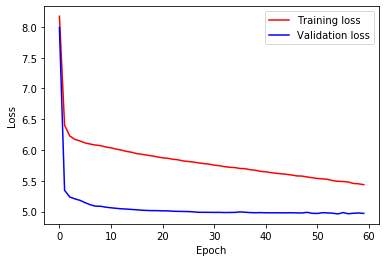

In [180]:
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Loss')
#plt.savefig('gdrive/My Drive/Colab Notebooks/Project DL/figures/loss.pdf')
plt.show()